# **Step 3 : Lexical Analysis**

**Goal**: Analyse frequencies, co-occurrences and lexical specificities

**Conducted analysis**:
1. Global and per document frequencies
2. Co-occurrences around key terms ("AI agent", "autonomy", etc.)
3. N-grams (bigrams and trigrams)
4. TF-IDF (distinctive terms per institution)
5. Comparative analysis Consulting vs Academic vs Industry

**Output**: Visualizations and insights for report

## Setup Config & Imports

In [1]:
import warnings
warnings.filterwarnings('ignore')

# Imports
import json
import pickle
from pathlib import Path
from collections import Counter, defaultdict
from itertools import combinations

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# NLP
import nltk
from nltk import bigrams, trigrams
from nltk.collocations import BigramCollocationFinder, TrigramCollocationFinder
from nltk.collocations import BigramAssocMeasures, TrigramAssocMeasures

# Lexical Analysis
from sklearn.feature_extraction.text import TfidfVectorizer
from wordcloud import WordCloud

# Progress bar
from tqdm.notebook import tqdm

# Viz Config
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl")
%matplotlib inline

plt.rcParams['figure.dpi'] = 100
plt.rcParams['savefig.dpi'] = 300
plt.rcParams['font.size'] = 10

print("✔ Imports")

✔ Imports


## Load processed corpus

In [2]:
# Paths
PROJECT_ROOT = Path.cwd().parent
PROCESSED_DATA = PROJECT_ROOT / "data" / "processed"
CORPUS_FILE = PROCESSED_DATA / "preprocessed_corpus.pkl"
METADATA_FILE = PROCESSED_DATA / "metadata" / "corpus_metadata.json"

# Create folder for analysis results
ANALYSIS_DIR = PROCESSED_DATA / "analysis"
ANALYSIS_DIR.mkdir(exist_ok=True)

print(f"Analysis folder : {ANALYSIS_DIR}")

Analysis folder : c:\Users\hrobi\Documents\GitHub\language-of-autonomy\data\processed\analysis


In [3]:
# Load processed corpus
with open(CORPUS_FILE, 'rb') as f:
    processed_corpus = pickle.load(f)

# Load metadata
with open(METADATA_FILE, 'r', encoding='utf-8') as f:
    metadata = json.load(f)

print(f"✔ {len(processed_corpus)} documents loaded")

✔ 20 documents loaded


In [4]:
# Mapping doc_id -> source_type
doc_to_source = {doc_id: metadata[doc_id]['source_type'] 
                 for doc_id in processed_corpus.keys()}

print(f"\nType distribution:")
for source_type, count in Counter(doc_to_source.values()).items():
    print(f"  • {source_type:15} : {count} document(s)")


Type distribution:
  • Consulting      : 7 document(s)
  • Industry        : 5 document(s)
  • Academic        : 4 document(s)
  • Policy          : 4 document(s)


## Global frequencies analysis

### Corpus frequencies

In [5]:
# Aggregate all tokens
all_tokens = []
for doc_data in processed_corpus.values():
    all_tokens.extend(doc_data['tokens'])

# Frequencies counter
global_freq = Counter(all_tokens)
vocab_size = len(global_freq)
total_tokens = len(all_tokens)

print(f"\nUnique vocabulary   : {vocab_size:,} words")
print(f"Tokens count        : {total_tokens:,}")


Unique vocabulary   : 10,211 words
Tokens count        : 83,298


In [6]:
print("TOP 50 MOST FREQUENT WORDS")
top_50 = global_freq.most_common(50)
for i, (word, count) in enumerate(top_50, 1):
    freq_pct = (count / total_tokens) * 100
    print(f"{i:2}. {word:20} : {count:5,} ({freq_pct:5.2f}%)")

TOP 50 MOST FREQUENT WORDS
 1. agent                : 1,896 ( 2.28%)
 2. agentic              : 1,293 ( 1.55%)
 3. system               : 1,090 ( 1.31%)
 4. data                 :   602 ( 0.72%)
 5. model                :   502 ( 0.60%)
 6. human                :   500 ( 0.60%)
 7. task                 :   410 ( 0.49%)
 8. risk                 :   375 ( 0.45%)
 9. technology           :   371 ( 0.45%)
10. value                :   362 ( 0.43%)
11. customer             :   357 ( 0.43%)
12. organization         :   346 ( 0.42%)
13. process              :   343 ( 0.41%)
14. service              :   322 ( 0.39%)
15. tool                 :   321 ( 0.39%)
16. business             :   305 ( 0.37%)
17. time                 :   299 ( 0.36%)
18. company              :   270 ( 0.32%)
19. user                 :   268 ( 0.32%)
20. work                 :   256 ( 0.31%)
21. base                 :   251 ( 0.30%)
22. need                 :   249 ( 0.30%)
23. case                 :   242 ( 0.29%)
24. bui

### Global frequencies visualization

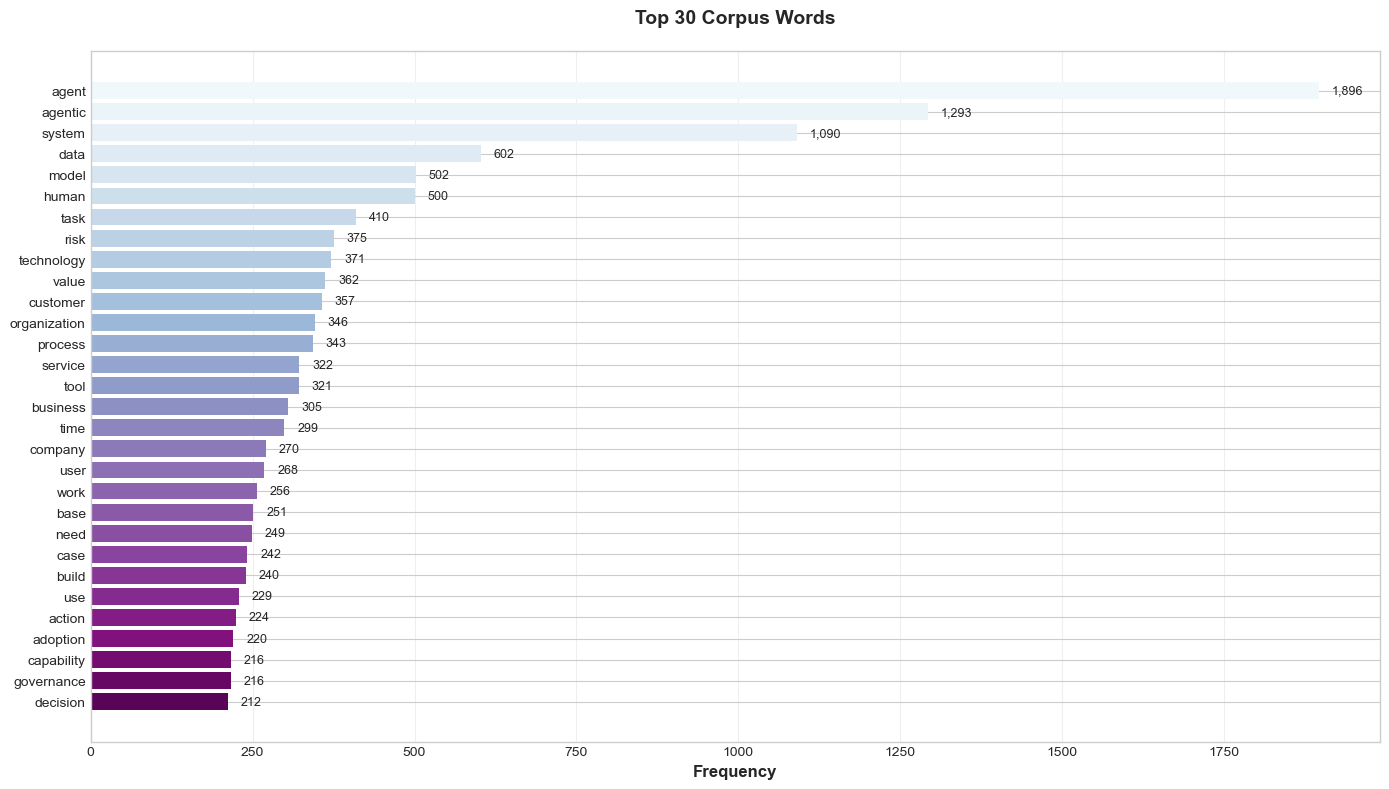

✔ Graph saved to: c:\Users\hrobi\Documents\GitHub\language-of-autonomy\data\processed\analysis\top30_global_frequencies.png


In [7]:
# Top 30
top_30_words = [word for word, _ in global_freq.most_common(30)]
top_30_counts = [count for _, count in global_freq.most_common(30)]

# Viz plot
fig, ax = plt.subplots(figsize=(14, 8))

colors = sns.color_palette('BuPu', len(top_30_counts))
bars = ax.barh(range(30), top_30_counts, color=colors)

ax.set_yticks(range(30))
ax.set_yticklabels(top_30_words)
ax.invert_yaxis()
ax.set_xlabel('Frequency', fontsize=12, fontweight='bold')
ax.set_title('Top 30 Corpus Words', fontsize=14, fontweight='bold', pad=20)
ax.grid(axis='x', alpha=0.3)

# Add values on bar
for i, (bar, count) in enumerate(zip(bars, top_30_counts)):
    ax.text(count + 20, i, f'{count:,}', va='center', fontsize=9)

plt.tight_layout()
plt.savefig(ANALYSIS_DIR / 'top30_global_frequencies.png', bbox_inches='tight')
plt.show()

print(f"✔ Graph saved to: {ANALYSIS_DIR / 'top30_global_frequencies.png'}")

### Refine global corpus WordCloud

In [8]:
# Optimize parameters
wordcloud = WordCloud(
    width=2000, 
    height=1000,
    background_color='white',
    colormap='BuPu',
    max_words=150,
    relative_scaling=0.5,
    min_font_size=12,
    collocations=False  # Avoid repetitions
).generate_from_frequencies(global_freq)

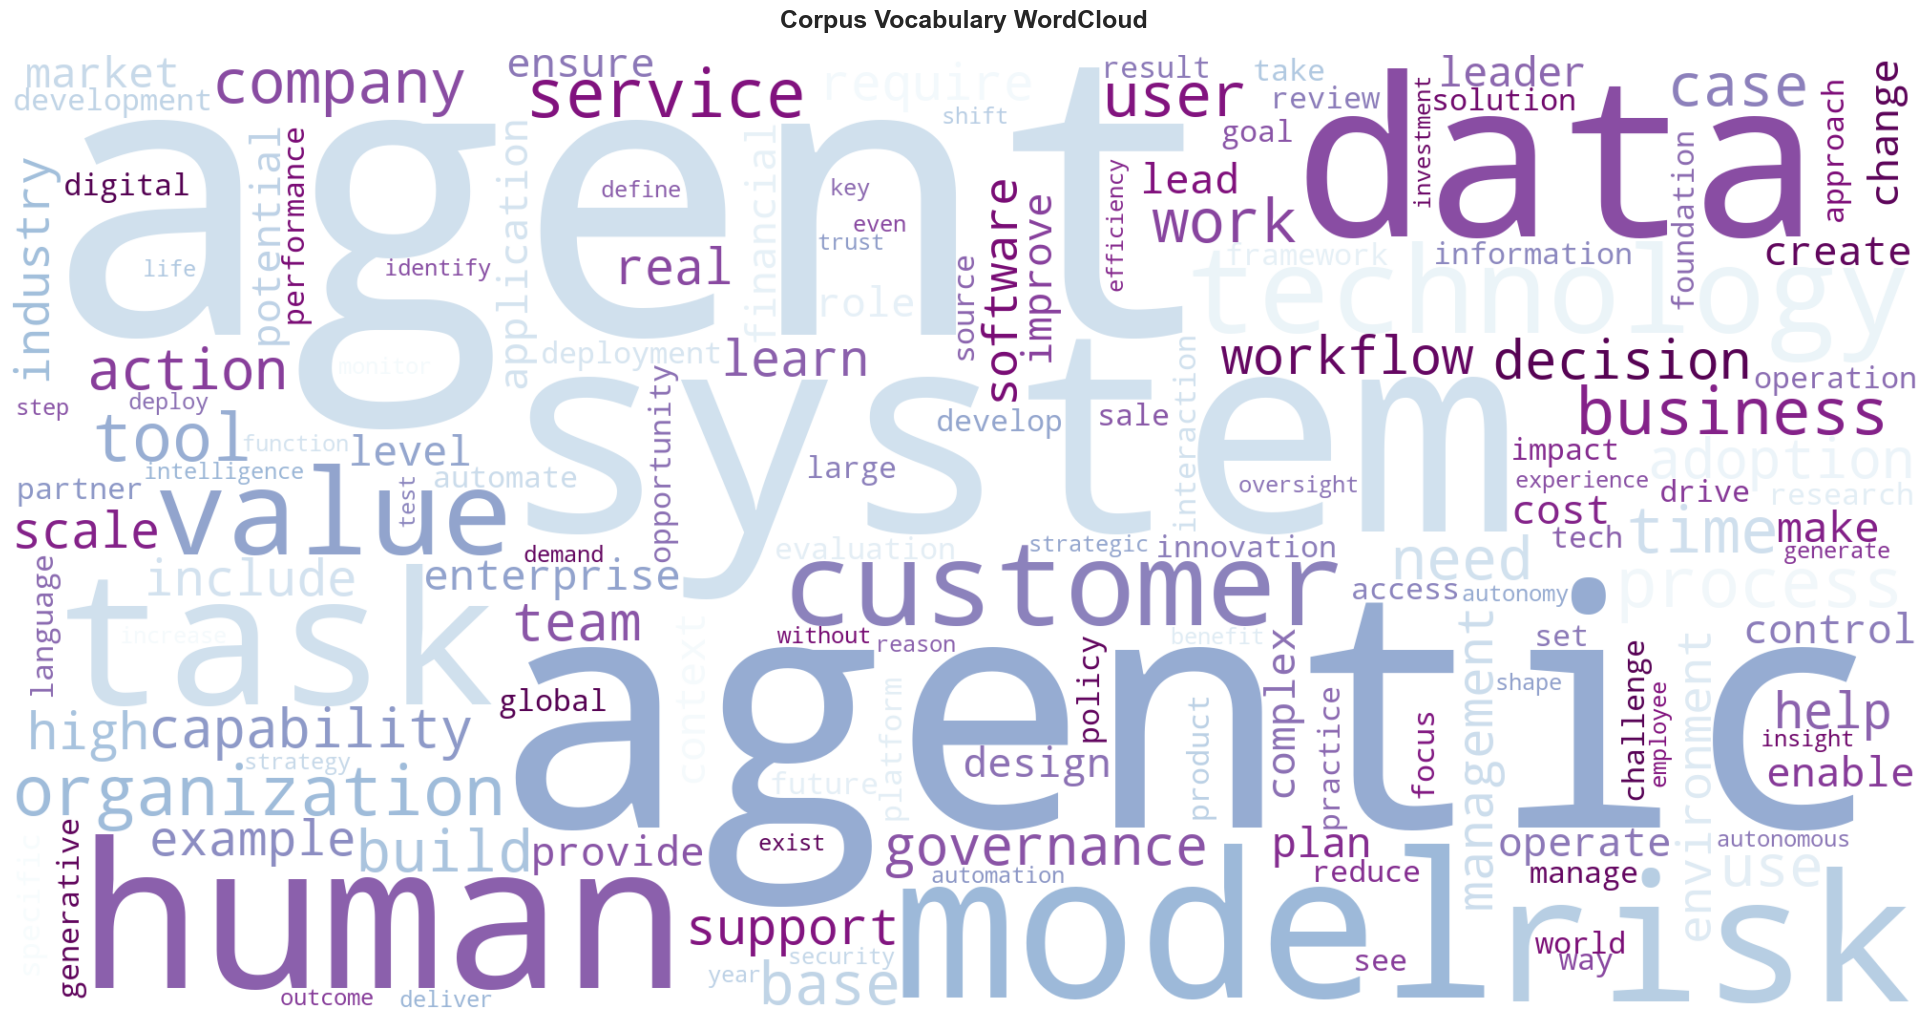

✔ WordCloud saved to: c:\Users\hrobi\Documents\GitHub\language-of-autonomy\data\processed\analysis\wordcloud_global.png


In [9]:
fig, ax = plt.subplots(figsize=(20, 10))
ax.imshow(wordcloud, interpolation='bilinear')
ax.axis('off')
ax.set_title('Corpus Vocabulary WordCloud', 
             fontsize=18, fontweight='bold', pad=20)

plt.tight_layout(pad=0)
plt.savefig(ANALYSIS_DIR / 'wordcloud_global.png', bbox_inches='tight')
plt.show()

print(f"✔ WordCloud saved to: {ANALYSIS_DIR / 'wordcloud_global.png'}")

## Document-level analysis

### Document-level frequencies

In [10]:
# Count frequencies for each doc
doc_frequencies = {}
for doc_id, doc_data in processed_corpus.items():
    doc_frequencies[doc_id] = Counter(doc_data['tokens'])

In [11]:
for doc_id in list(processed_corpus.keys())[:3]:  # Show first 3 docs top 10 freq
    filename = metadata[doc_id]['filename']
    source_type = doc_to_source[doc_id]
    
    print(f"{filename} ({source_type})")
    
    top_10 = doc_frequencies[doc_id].most_common(10)
    for i, (word, count) in enumerate(top_10, 1):
        print(f"  {i:2}. {word:20} : {count:4,}")

print(f"\n... (see CSV for all documents)")

Bain_report_technology_report_2025.pdf (Consulting)
   1. technology           :  113
   2. data                 :  113
   3. company              :  108
   4. agent                :   92
   5. value                :   77
   6. tech                 :   72
   7. quantum              :   71
   8. software             :   66
   9. agentic              :   63
  10. need                 :   62
BCG_AI_Agents_2025.pdf (Consulting)
   1. agent                :   81
   2. human                :   16
   3. data                 :   13
   4. plan                 :   12
   5. use                  :   12
   6. task                 :   11
   7. business             :   10
   8. process              :    9
   9. environment          :    9
  10. intelligent          :    9
Deloitte_The_business_imperative_for_Agentic_AI_2025.pdf (Consulting)
   1. agentic              :  107
   2. agent                :   65
   3. business             :   42
   4. imperative           :   27
   5. organisation        

### Top words per document

In [12]:
# Create DataFrame for viz
top_n = 15

# Extract top 15 /doc
data_for_viz = []
for doc_id, freq_counter in doc_frequencies.items():
    top_words = freq_counter.most_common(top_n)
    filename_short = metadata[doc_id]['filename'][:25]
    
    for word, count in top_words:
        data_for_viz.append({
            'document': filename_short,
            'word': word,
            'count': count,
            'source_type': doc_to_source[doc_id]
        })

df_top_words = pd.DataFrame(data_for_viz)

In [13]:
# Create most frequent words heatmap
# Take the 20 most frequent global words
top_global_words = [w for w, _ in global_freq.most_common(20)]

# Create document x word matrix
heatmap_data = []
doc_labels = []

for doc_id in processed_corpus.keys():
    filename_short = metadata[doc_id]['filename'][:30]
    doc_labels.append(filename_short)
    
    row = []
    for word in top_global_words:
        row.append(doc_frequencies[doc_id].get(word, 0))
    heatmap_data.append(row)

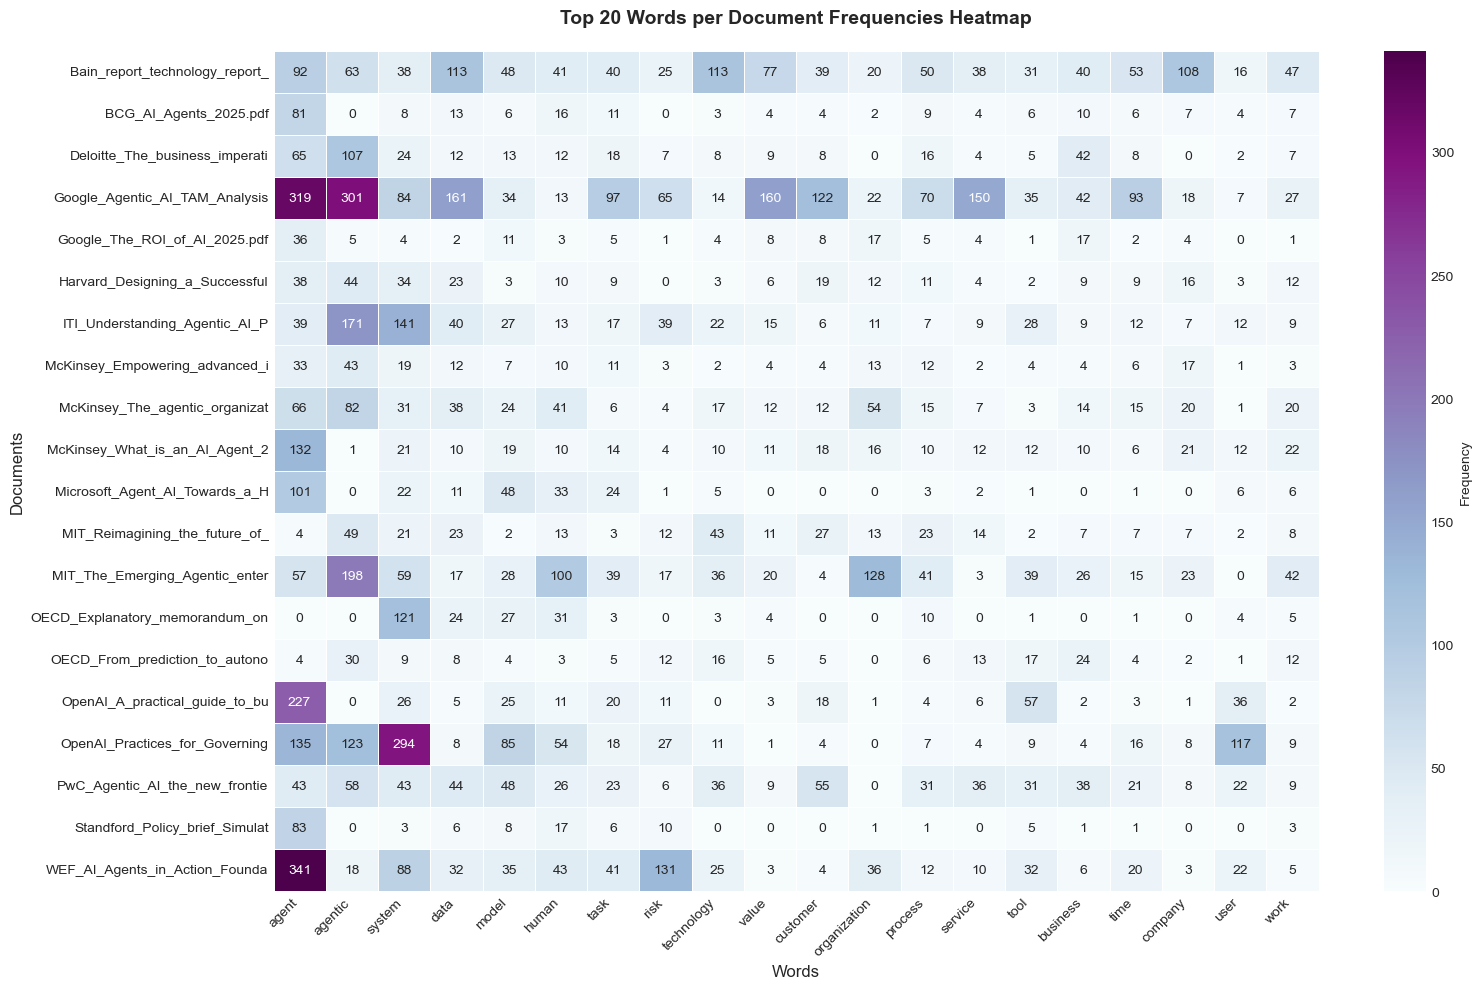

✔ Heatmap saved to: c:\Users\hrobi\Documents\GitHub\language-of-autonomy\data\processed\analysis\heatmap_top_words_by_doc.png


In [14]:
# Plot
fig, ax = plt.subplots(figsize=(16, 10))

heatmap_df = pd.DataFrame(heatmap_data, index=doc_labels, columns=top_global_words)
sns.heatmap(heatmap_df, annot=True, fmt='d', cmap='BuPu', 
            linewidths=0.5, cbar_kws={'label': 'Frequency'}, ax=ax)

ax.set_title('Top 20 Words per Document Frequencies Heatmap', 
             fontsize=14, fontweight='bold', pad=20)
ax.set_xlabel('Words', fontsize=12)
ax.set_ylabel('Documents', fontsize=12)

plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.savefig(ANALYSIS_DIR / 'heatmap_top_words_by_doc.png', bbox_inches='tight')
plt.show()

print(f"✔ Heatmap saved to: {ANALYSIS_DIR / 'heatmap_top_words_by_doc.png'}")

## Key words specific to domain

### Agentic AI key words frequency

In [15]:
# Define domain key words
KEY_TERMS = {
    'Core Concepts': ['agent', 'agentic', 'autonomy', 'autonomous', 'intelligence', 'ai', 'automation', 'automate'],
    'Implementation': ['system', 'model', 'architecture', 'framework', 'platform', 'deployment', 'integration', 'environment', 'infrastructure'],
    'Business Value': ['productivity', 'efficiency', 'automation', 'optimization', 'roi', 'value', 'benefit', 'performance', 'cost', 'investment'],
    'Workforce': ['workforce', 'employee', 'worker', 'work', 'human', 'job', 'skill', 'company', 'organization', 'industry'],
    'Technology': ['data', 'algorithm', 'learning', 'machine', 'generative', 'gen', 'genai'],
    'Governance': ['governance', 'risk', 'compliance', 'regulation', 'ethics', 'trust', 'policy', 'standard', 'adoption', 'plan'],
    'Operations': ['workflow', 'orchestration', 'process', 'task', 'operation', 'service'],
    'Assistance': ['copilot', 'assistant', 'support', 'augmentation', 'collaboration', 'tool', 'decision']
}

In [16]:
# Counts by each category
category_counts = defaultdict(int)
for category, terms in KEY_TERMS.items():
    for term in terms:
        category_counts[category] += global_freq.get(term, 0)

print("\nOccurrences by category:")
for category, count in sorted(category_counts.items(), key=lambda x: x[1], reverse=True):
    print(f"{category:20} : {count:5,} occurrences")


Occurrences by category:
Core Concepts        : 3,715 occurrences
Implementation       : 2,352 occurrences
Workforce            : 1,871 occurrences
Operations           : 1,450 occurrences
Governance           : 1,362 occurrences
Business Value       : 1,200 occurrences
Technology           :   928 occurrences
Assistance           :   858 occurrences


In [17]:
# Details by key terms
print("DETAILS BY KEY TERMS")
key_term_details = []
for category, terms in KEY_TERMS.items():
    print(f"\n{category}:")
    for term in terms:
        count = global_freq.get(term, 0)
        print(f"  • {term:20} : {count:4,}")
        key_term_details.append({
            'category': category,
            'term': term,
            'count': count
        })

df_key_terms = pd.DataFrame(key_term_details)

DETAILS BY KEY TERMS

Core Concepts:
  • agent                : 1,896
  • agentic              : 1,293
  • autonomy             :  104
  • autonomous           :   98
  • intelligence         :  108
  • ai                   :    2
  • automation           :  106
  • automate             :  108

Implementation:
  • system               : 1,090
  • model                :  502
  • architecture         :   81
  • framework            :  115
  • platform             :  112
  • deployment           :  144
  • integration          :   64
  • environment          :  172
  • infrastructure       :   72

Business Value:
  • productivity         :   74
  • efficiency           :   98
  • automation           :  106
  • optimization         :   28
  • roi                  :   36
  • value                :  362
  • benefit              :  101
  • performance          :  138
  • cost                 :  153
  • investment           :  104

Workforce:
  • workforce            :   58
  • employee      

### Key term visualization by categories

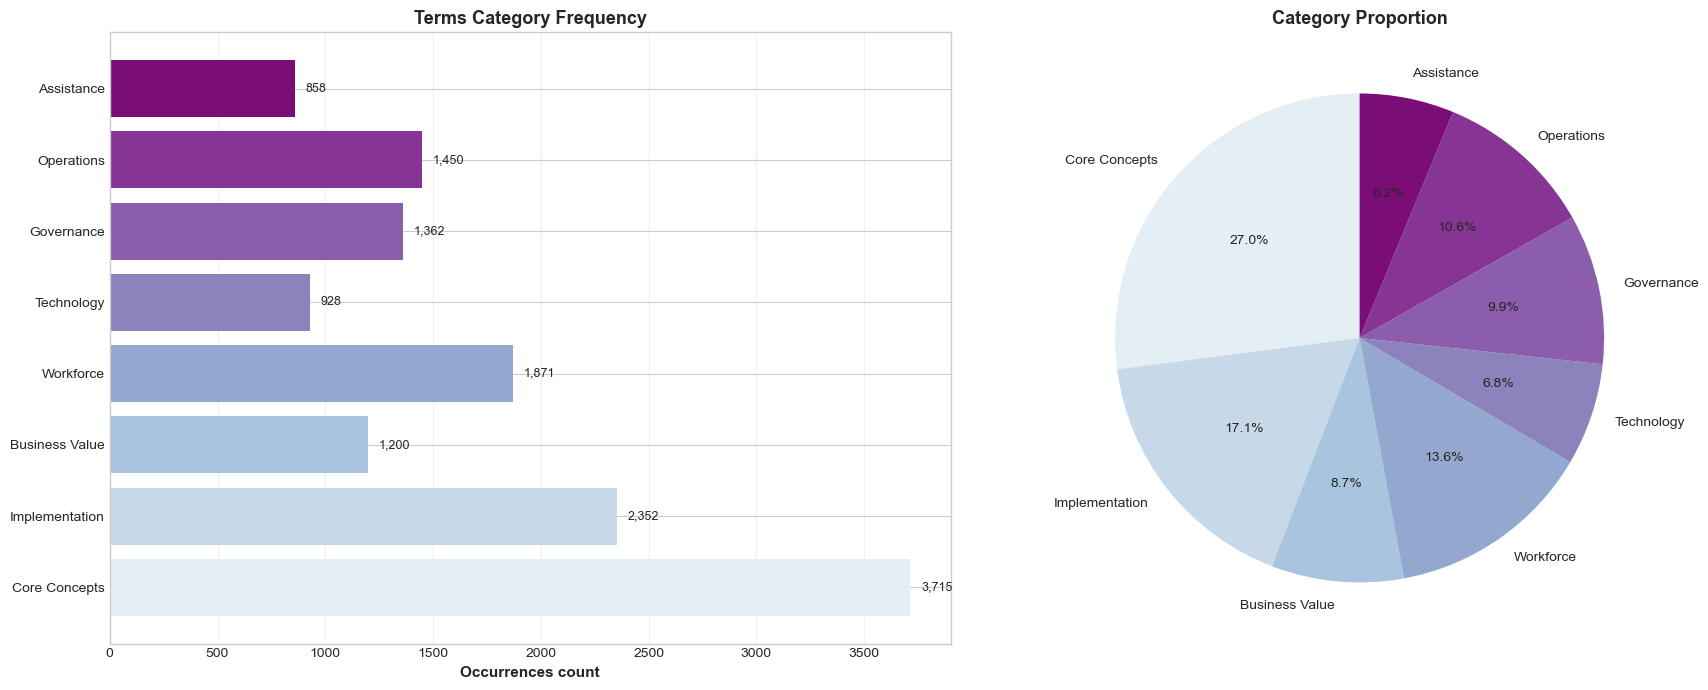

✔ Graph saved to: c:\Users\hrobi\Documents\GitHub\language-of-autonomy\data\processed\analysis\key_terms_categories.png


In [18]:
fig, axes = plt.subplots(1, 2, figsize=(18, 7))

# Horizontal bar chart
categories = list(category_counts.keys())
counts = list(category_counts.values())
colors_cat = sns.color_palette('BuPu', len(categories))

axes[0].barh(categories, counts, color=colors_cat)
axes[0].set_xlabel('Occurrences count', fontsize=11, fontweight='bold')
axes[0].set_title('Terms Category Frequency', fontsize=13, fontweight='bold')
axes[0].grid(axis='x', alpha=0.3)

for i, (cat, count) in enumerate(zip(categories, counts)):
    axes[0].text(count + 50, i, f'{count:,}', va='center', fontsize=9)

# Pie chart
axes[1].pie(counts, labels=categories, autopct='%1.1f%%', startangle=90,
           colors=colors_cat)
axes[1].set_title('Category Proportion', fontsize=13, fontweight='bold')

plt.tight_layout()
plt.savefig(ANALYSIS_DIR / 'key_terms_categories.png', bbox_inches='tight')
plt.show()

print(f"✔ Graph saved to: {ANALYSIS_DIR / 'key_terms_categories.png'}")

### Top Termes by category

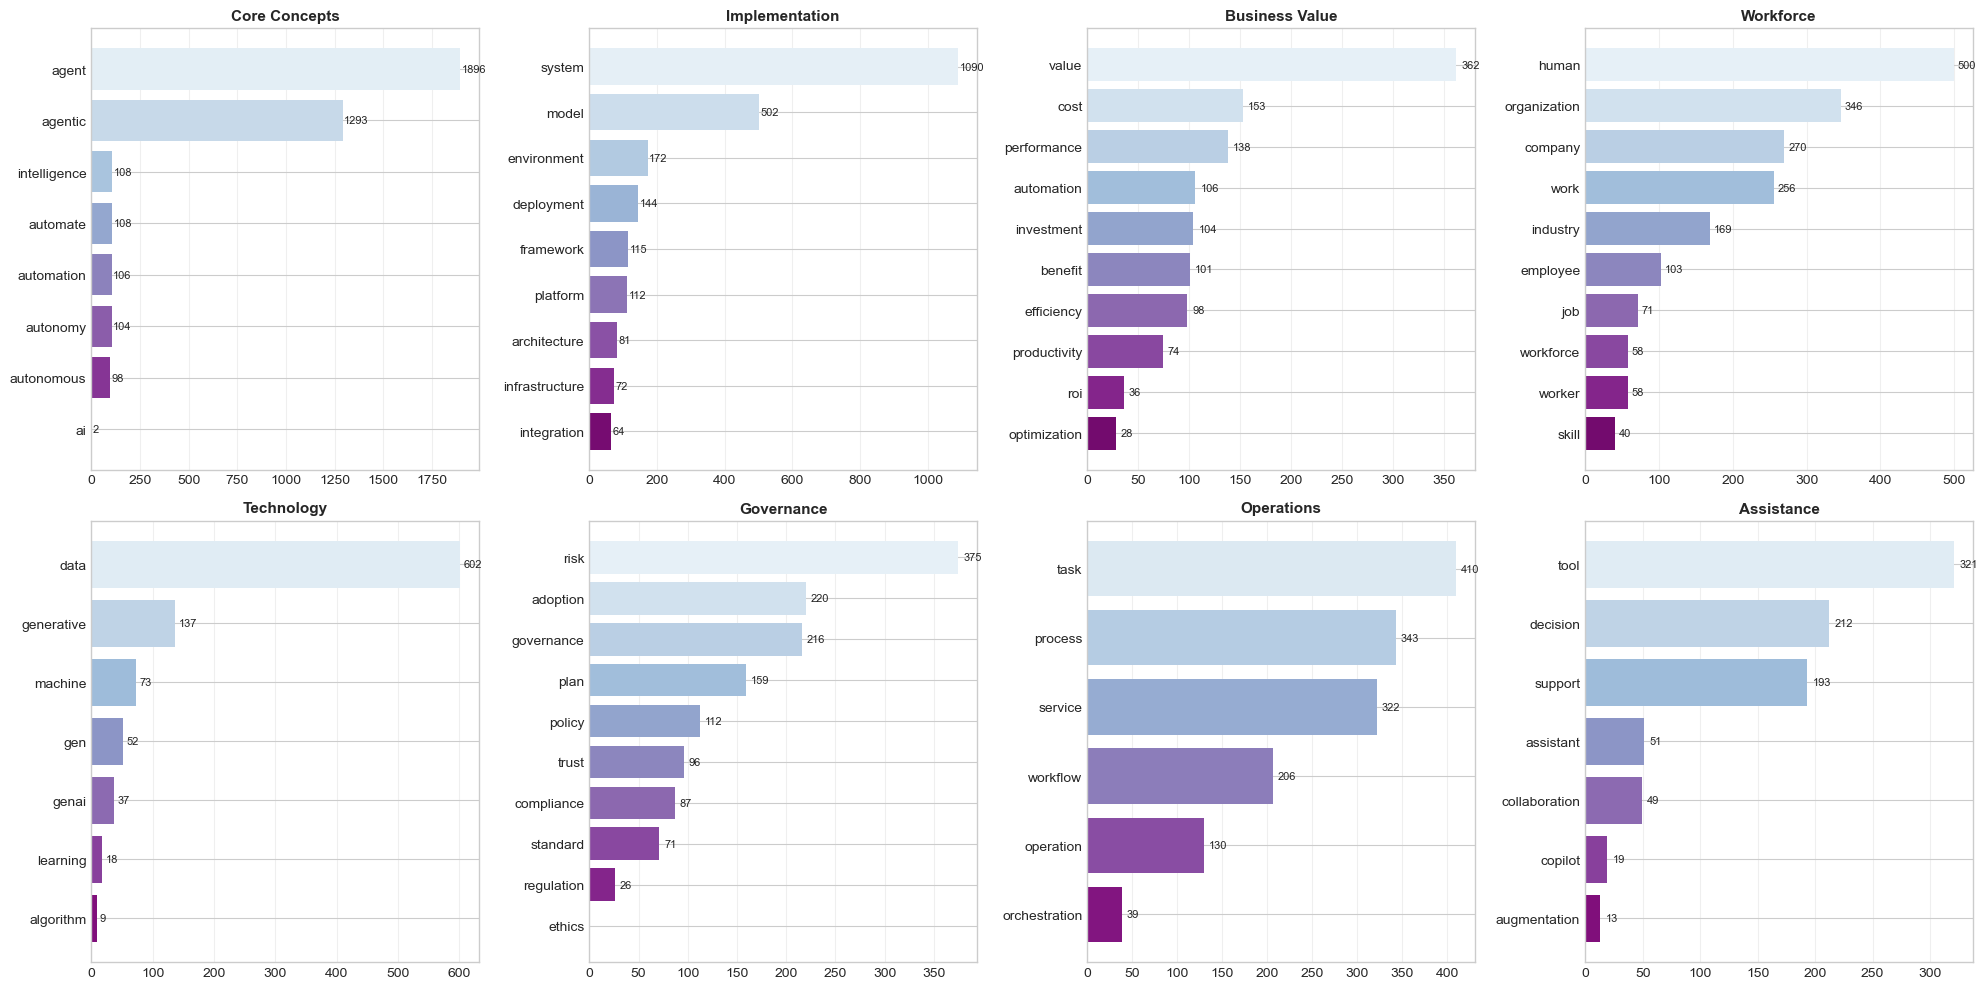

✔ Graph saved to: c:\Users\hrobi\Documents\GitHub\language-of-autonomy\data\processed\analysis\key_terms_detailed.png


In [19]:
n_categories = len(KEY_TERMS)
fig, axes = plt.subplots(2, 4, figsize=(20, 10))
axes = axes.flatten()

for idx, (category, terms) in enumerate(KEY_TERMS.items()):
    # Term frequency
    term_counts = [(term, global_freq.get(term, 0)) for term in terms]
    term_counts.sort(key=lambda x: x[1], reverse=True)
    
    words = [t[0] for t in term_counts]
    counts = [t[1] for t in term_counts]
    
    # Plotting
    ax = axes[idx]
    colors = sns.color_palette('BuPu', len(words))
    ax.barh(words, counts, color=colors)
    ax.set_title(category, fontsize=11, fontweight='bold')
    ax.invert_yaxis()
    ax.grid(axis='x', alpha=0.3)
    
    for i, (word, count) in enumerate(zip(words, counts)):
        if count > 0:
            ax.text(count + 5, i, str(count), va='center', fontsize=8)

plt.tight_layout()
plt.savefig(ANALYSIS_DIR / 'key_terms_detailed.png', bbox_inches='tight')
plt.show()

print(f"✔ Graph saved to: {ANALYSIS_DIR / 'key_terms_detailed.png'}")

## Co-occurrences surrounding key terms

### Co-occurrences with "agent" / "agentic"

In [20]:
def find_cooccurrences(tokens, target_word, window=5):
    """
    Find words that co-occur with a target word within a given window.
    
    Args:
        tokens: List of tokens
        target_word: Target word
        window: Window size (words before and after)
    
    Returns:
        Counter of co-occurrences
    """
    cooccur = Counter()
    
    for i, token in enumerate(tokens):
        if token == target_word:
            # Before window
            start = max(0, i - window)
            # After window
            end = min(len(tokens), i + window + 1)
            
            # Add all words in window (except target word)
            for j in range(start, end):
                if j != i:
                    cooccur[tokens[j]] += 1
    
    return cooccur

In [21]:
# Analyze co-occurrences for central terms
TARGET_WORDS = ['agent', 'agentic', 'autonomy', 'autonomous', 'ai']

cooccurrence_results = {}

for target in TARGET_WORDS:
    print(f"Co-occurrences with '{target}' (±5 words)")
    
    cooccur = find_cooccurrences(all_tokens, target, window=5)
    cooccurrence_results[target] = cooccur
    
    # Top 20
    top_20 = cooccur.most_common(20)
    for i, (word, count) in enumerate(top_20, 1):
        print(f"  {i:2}. {word:20} : {count:4,}")

Co-occurrences with 'agent' (±5 words)
   1. agent                : 1,096
   2. system               :  272
   3. human                :  125
   4. action               :  119
   5. governance           :  113
   6. task                 :  111
   7. agentic              :  110
   8. user                 :  104
   9. tool                 :  104
  10. evaluation           :   97
  11. workflow             :   96
  12. data                 :   96
  13. customer             :   92
  14. foundation           :   91
  15. use                  :   86
  16. model                :   84
  17. organization         :   83
  18. risk                 :   80
  19. build                :   78
  20. work                 :   76
Co-occurrences with 'agentic' (±5 words)
   1. system               :  414
   2. agentic              :  382
   3. adoption             :  165
   4. organization         :  112
   5. agent                :  110
   6. value                :  105
   7. business             :  100
 

### Co-occurrences visualization

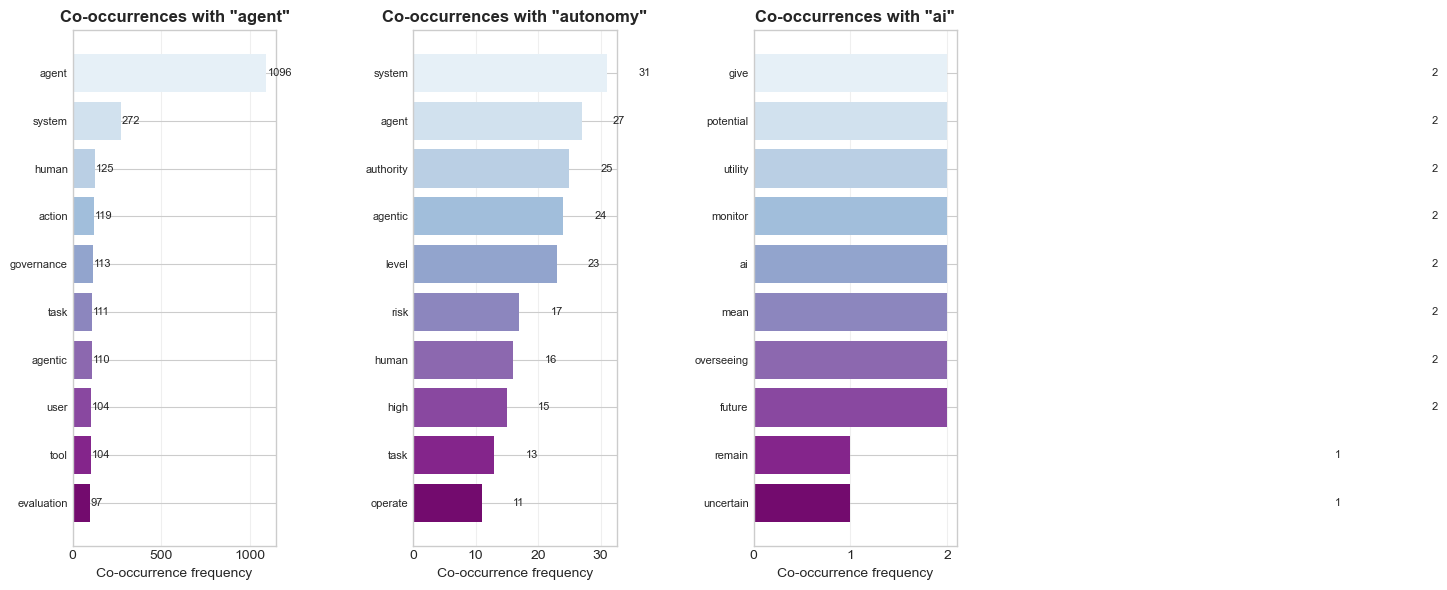

✔ Graph saved to: c:\Users\hrobi\Documents\GitHub\language-of-autonomy\data\processed\analysis\cooccurrences_main_terms.png


In [22]:
# Create graph for co-occurrences of the 3 main terms
main_targets = ['agent', 'autonomy', 'ai']

fig, axes = plt.subplots(1, 3, figsize=(7*len(main_targets), 6))

for idx, target in enumerate(main_targets):
    cooccur = cooccurrence_results[target]
    top_10 = cooccur.most_common(10)
    
    words = [w for w, _ in top_10]
    counts = [c for _, c in top_10]
    
    ax = axes[idx]
    colors = sns.color_palette('BuPu', len(top_10))
    ax.barh(range(10), counts, color=colors)
    ax.set_yticks(range(10))
    ax.set_yticklabels(words, fontsize=8)
    ax.invert_yaxis()
    ax.set_xlabel('Co-occurrence frequency', fontsize=10)
    ax.set_title(f'Co-occurrences with "{target}"', fontsize=12, fontweight='bold')
    ax.grid(axis='x', alpha=0.3)
    
    for i, count in enumerate(counts):
        ax.text(count + 5, i, str(count), va='center', fontsize=8)

plt.tight_layout()
plt.savefig(ANALYSIS_DIR / 'cooccurrences_main_terms.png', bbox_inches='tight')
plt.show()

print(f"✔ Graph saved to: {ANALYSIS_DIR / 'cooccurrences_main_terms.png'}")

## N-grams (Bigrams and Trigrams) 

### Bigrams extraction (2-grams)

In [23]:
# Generate bigrams
bigram_list = list(bigrams(all_tokens))
bigram_freq = Counter(bigram_list)

print(f"\nBigrams count: {len(bigram_freq):,}")


Bigrams count: 64,439


In [24]:
print("TOP 30 BIGRAMS")
top_30_bigrams = bigram_freq.most_common(30)
for i, (bigram, count) in enumerate(top_30_bigrams, 1):
    bigram_str = ' '.join(bigram)
    print(f"{i:2}. {bigram_str:35} : {count:4,}")

TOP 30 BIGRAMS
 1. agentic system                      :  257
 2. value pool                          :   80
 3. agent agent                         :   78
 4. real time                           :   72
 5. artificial intelligence             :   67
 6. customer service                    :   64
 7. shape future                        :   58
 8. language model                      :   55
 9. decision make                       :   55
10. agent system                        :   49
11. real world                          :   48
12. life cycle                          :   48
13. evaluation governance               :   44
14. agent action                        :   41
15. agentic adoption                    :   40
16. risk assessment                     :   38
17. financial service                   :   38
18. adoption agentic                    :   38
19. generative agent                    :   38
20. supply chain                        :   37
21. agentic organization                :   3

### Bigrams with collocation measures (PMI)

In [25]:
# Use NLTK to identify significative collocations
bigram_finder = BigramCollocationFinder.from_words(all_tokens)

# Filter bigrams which appear at least 5 times
bigram_finder.apply_freq_filter(5)

# Bigrams w/ PMI (Pointwise Mutual Information)
bigram_measures = BigramAssocMeasures()
top_bigrams_pmi = bigram_finder.nbest(bigram_measures.pmi, 30)

print("TOP 30 BIGRAMS MEASURES (PMI)")
for i, bigram in enumerate(top_bigrams_pmi, 1):
    bigram_str = ' '.join(bigram)
    count = bigram_freq[bigram]
    print(f"{i:2}. {bigram_str:35} : {count:4,} occurrences")

TOP 30 BIGRAMS MEASURES (PMI)
 1. await runner                        :    5 occurrences
 2. iso iec                             :    5 occurrences
 3. explanatory memorandum              :   18 occurrences
 4. regional split                      :    6 occurrences
 5. fine tune                           :   15 occurrences
 6. family examples                     :   10 occurrences
 7. drug discovery                      :    9 occurrences
 8. north america                       :   10 occurrences
 9. vice president                      :   20 occurrences
10. moore law                           :    7 occurrences
11. page pmlr                           :    8 occurrences
12. administrative burden               :    6 occurrences
13. kyc verification                    :    5 occurrences
14. strongly agree                      :    5 occurrences
15. ideal ideal                         :    8 occurrences
16. region city                         :    8 occurrences
17. conference fairness   

### Bigrams visualization

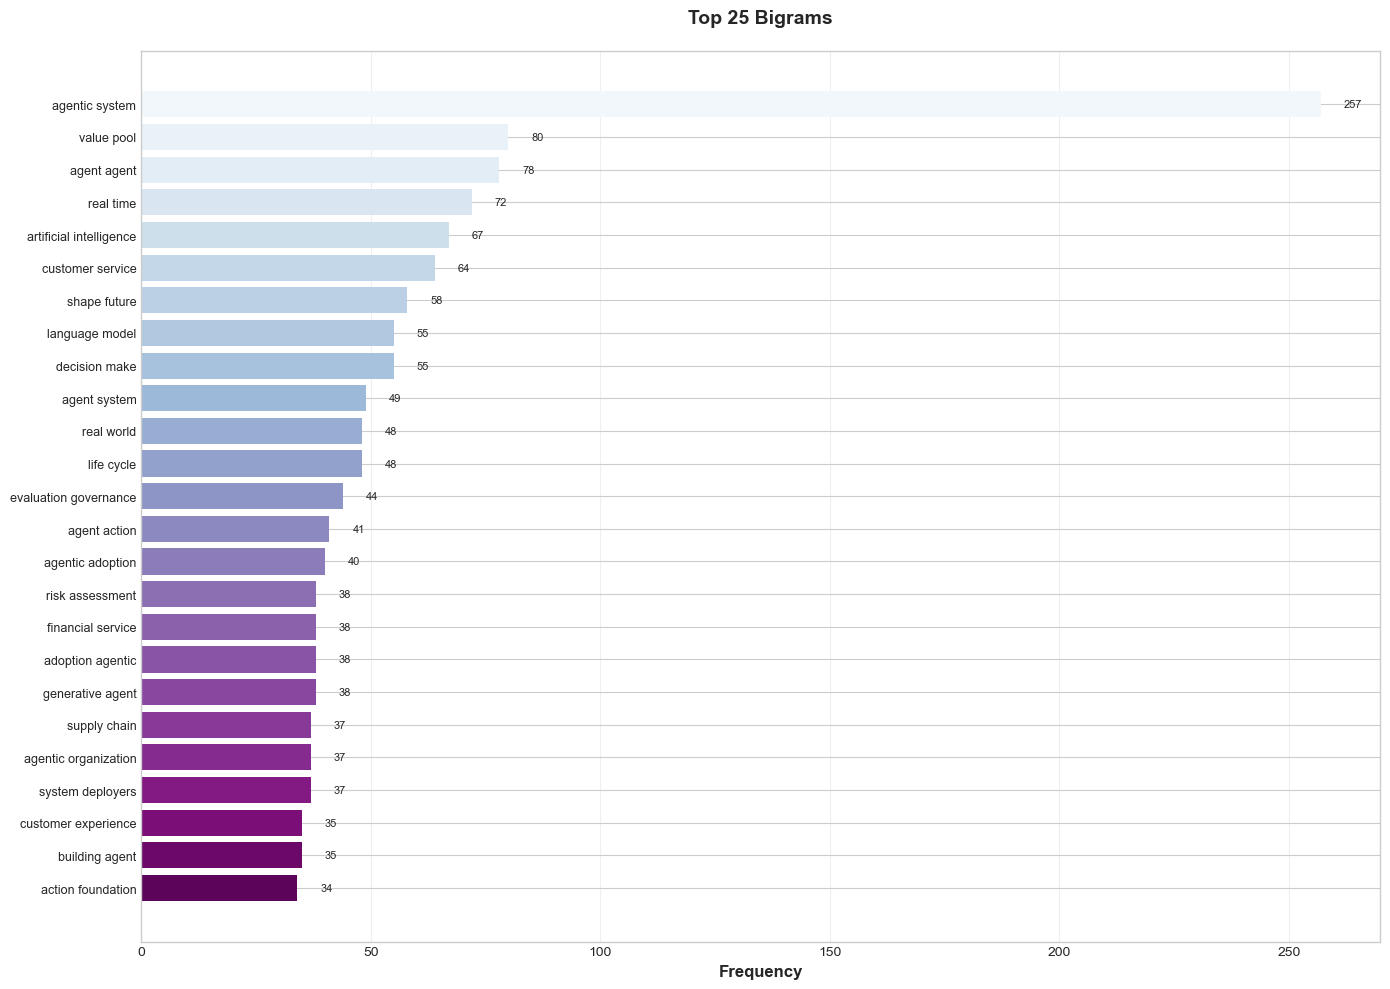

✔ Graph saved to: c:\Users\hrobi\Documents\GitHub\language-of-autonomy\data\processed\analysis\top25_bigrams.png


In [26]:
# Top 25 bigrams for viz
top_25_bigrams = bigram_freq.most_common(25)
bigram_labels = [' '.join(bg) for bg, _ in top_25_bigrams]
bigram_counts = [count for _, count in top_25_bigrams]

fig, ax = plt.subplots(figsize=(14, 10))

colors = sns.color_palette('BuPu', len(top_25_bigrams))
bars = ax.barh(range(25), bigram_counts, color=colors)

ax.set_yticks(range(25))
ax.set_yticklabels(bigram_labels, fontsize=9)
ax.invert_yaxis()
ax.set_xlabel('Frequency', fontsize=12, fontweight='bold')
ax.set_title('Top 25 Bigrams', fontsize=14, fontweight='bold', pad=20)
ax.grid(axis='x', alpha=0.3)

for i, count in enumerate(bigram_counts):
    ax.text(count + 5, i, str(count), va='center', fontsize=8)

plt.tight_layout()
plt.savefig(ANALYSIS_DIR / 'top25_bigrams.png', bbox_inches='tight')
plt.show()

print(f"✔ Graph saved to: {ANALYSIS_DIR / 'top25_bigrams.png'}")

### Trigrams extraction (3-grams)

In [27]:
# Generate trigrams
trigram_list = list(trigrams(all_tokens))
trigram_freq = Counter(trigram_list)

print(f"\nTrigrams count: {len(trigram_freq):,}")


Trigrams count: 78,896


In [28]:
print("TOP 30 TRIGRAMS")
top_30_trigrams = trigram_freq.most_common(30)
for i, (trigram, count) in enumerate(top_30_trigrams, 1):
    trigram_str = ' '.join(trigram)
    print(f"{i:2}. {trigram_str:40} : {count:4,}")

TOP 30 TRIGRAMS
 1. agent action foundation                  :   34
 2. action foundation evaluation             :   34
 3. foundation evaluation governance         :   34
 4. service value pool                       :   31
 5. practical guide building                 :   31
 6. guide building agent                     :   31
 7. large language model                     :   30
 8. business imperative agentic              :   27
 9. technology review insight                :   24
10. plan adopt agentic                       :   21
11. emerge agentic enterprise                :   19
12. agentic enterprise leader                :   19
13. enterprise leader navigate               :   19
14. leader navigate age                      :   19
15. technology stack financial               :   19
16. stack financial impact                   :   19
17. financial impact financial               :   19
18. impact financial benefit                 :   19
19. financial benefit model                  :  

### Trigrams visualization

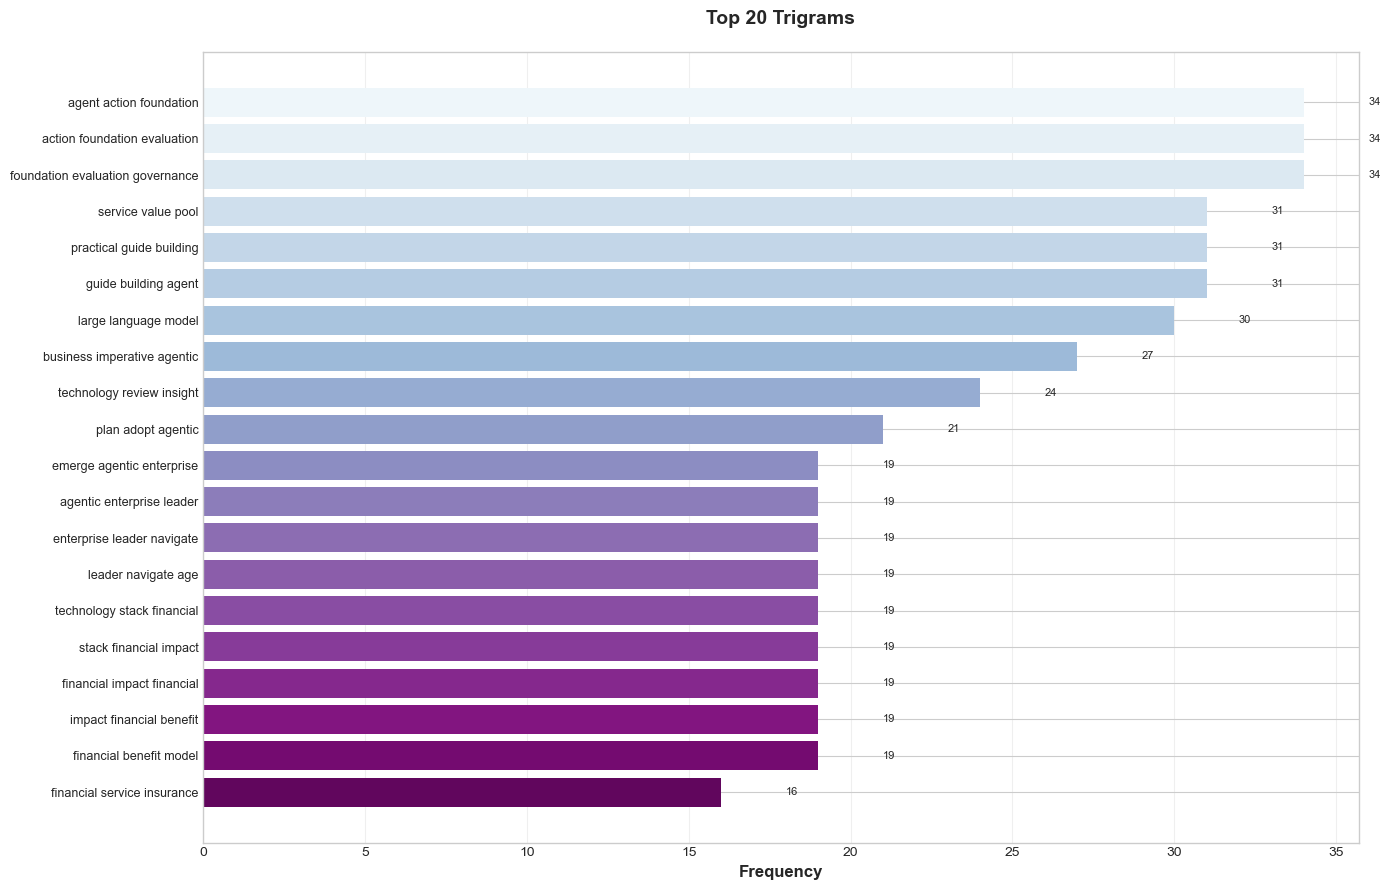

✔ Graph saved to: c:\Users\hrobi\Documents\GitHub\language-of-autonomy\data\processed\analysis\top20_trigrams.png


In [29]:
# Top 20 trigrams
top_20_trigrams = trigram_freq.most_common(20)
trigram_labels = [' '.join(tg) for tg, _ in top_20_trigrams]
trigram_counts = [count for _, count in top_20_trigrams]

fig, ax = plt.subplots(figsize=(14, 9))

colors = sns.color_palette('BuPu', len(top_20_trigrams))
bars = ax.barh(range(20), trigram_counts, color=colors)

ax.set_yticks(range(20))
ax.set_yticklabels(trigram_labels, fontsize=9)
ax.invert_yaxis()
ax.set_xlabel('Frequency', fontsize=12, fontweight='bold')
ax.set_title('Top 20 Trigrams', fontsize=14, fontweight='bold', pad=20)
ax.grid(axis='x', alpha=0.3)

for i, count in enumerate(trigram_counts):
    ax.text(count + 2, i, str(count), va='center', fontsize=8)

plt.tight_layout()
plt.savefig(ANALYSIS_DIR / 'top20_trigrams.png', bbox_inches='tight')
plt.show()

print(f"✔ Graph saved to: {ANALYSIS_DIR / 'top20_trigrams.png'}")

## TF-IDF for distinct terms per document

### Compute TF-IDF

In [30]:
# TF-IDF document preparation (join tokens in single text)
documents_for_tfidf = []
doc_ids_ordered = []

for doc_id, doc_data in processed_corpus.items():
    documents_for_tfidf.append(' '.join(doc_data['tokens']))
    doc_ids_ordered.append(doc_id)

# TF-IDF computation using TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer(
    # max_features=500,  # Top 500 terms
    min_df=2,          # Min 1 doc
    max_df=0.90,       # Max 95% of docs
    # ngram_range=(1, 1) # Unigrams only
)

tfidf_matrix = tfidf_vectorizer.fit_transform(documents_for_tfidf)
feature_names = tfidf_vectorizer.get_feature_names_out()

print(f"\n✔ TF-IDF matrix: {tfidf_matrix.shape}")
print(f"   {tfidf_matrix.shape[0]} documents × {tfidf_matrix.shape[1]} terms")


✔ TF-IDF matrix: (20, 3365)
   20 documents × 3365 terms


### Top TF-IDF terms by document

In [31]:
print("TOP 15 TF-IDF TERMS PER DOCUMENT")

# Convert to DataFrame for easier analysis
tfidf_df = pd.DataFrame(
    tfidf_matrix.toarray(),
    index=doc_ids_ordered,
    columns=feature_names
)

# Extract top terms for each doc
top_terms_per_doc = {}
for doc_id in doc_ids_ordered:
    # TF-IDF score for doc
    doc_scores = tfidf_df.loc[doc_id].sort_values(ascending=False)
    top_15 = doc_scores.head(15)
    
    top_terms_per_doc[doc_id] = top_15.to_dict()
    
    if list(doc_ids_ordered).index(doc_id) < 3: # first 3
        filename = metadata[doc_id]['filename']
        source_type = doc_to_source[doc_id]
        
        print(f"\n{filename} ({source_type})")
        for i, (term, score) in enumerate(top_15.items(), 1):
            print(f"   {i:2}. {term:25} : {score:.4f}")

print(f"\n... (see CSV for all docs)")

TOP 15 TF-IDF TERMS PER DOCUMENT

Bain_report_technology_report_2025.pdf (Consulting)
    1. company                   : 0.2156
    2. saas                      : 0.2153
    3. tech                      : 0.2067
    4. technology                : 0.2049
    5. compute                   : 0.1705
    6. software                  : 0.1454
    7. humanoid                  : 0.1402
    8. value                     : 0.1396
    9. year                      : 0.1390
   10. agentic                   : 0.1321
   11. market                    : 0.1145
   12. see                       : 0.1046
   13. deal                      : 0.1043
   14. leader                    : 0.1035
   15. billion                   : 0.1003

BCG_AI_Agents_2025.pdf (Consulting)
    1. plan                      : 0.2371
    2. intelligent               : 0.2290
    3. memory                    : 0.1880
    4. environment               : 0.1867
    5. business                  : 0.1795
    6. observe                   : 0.

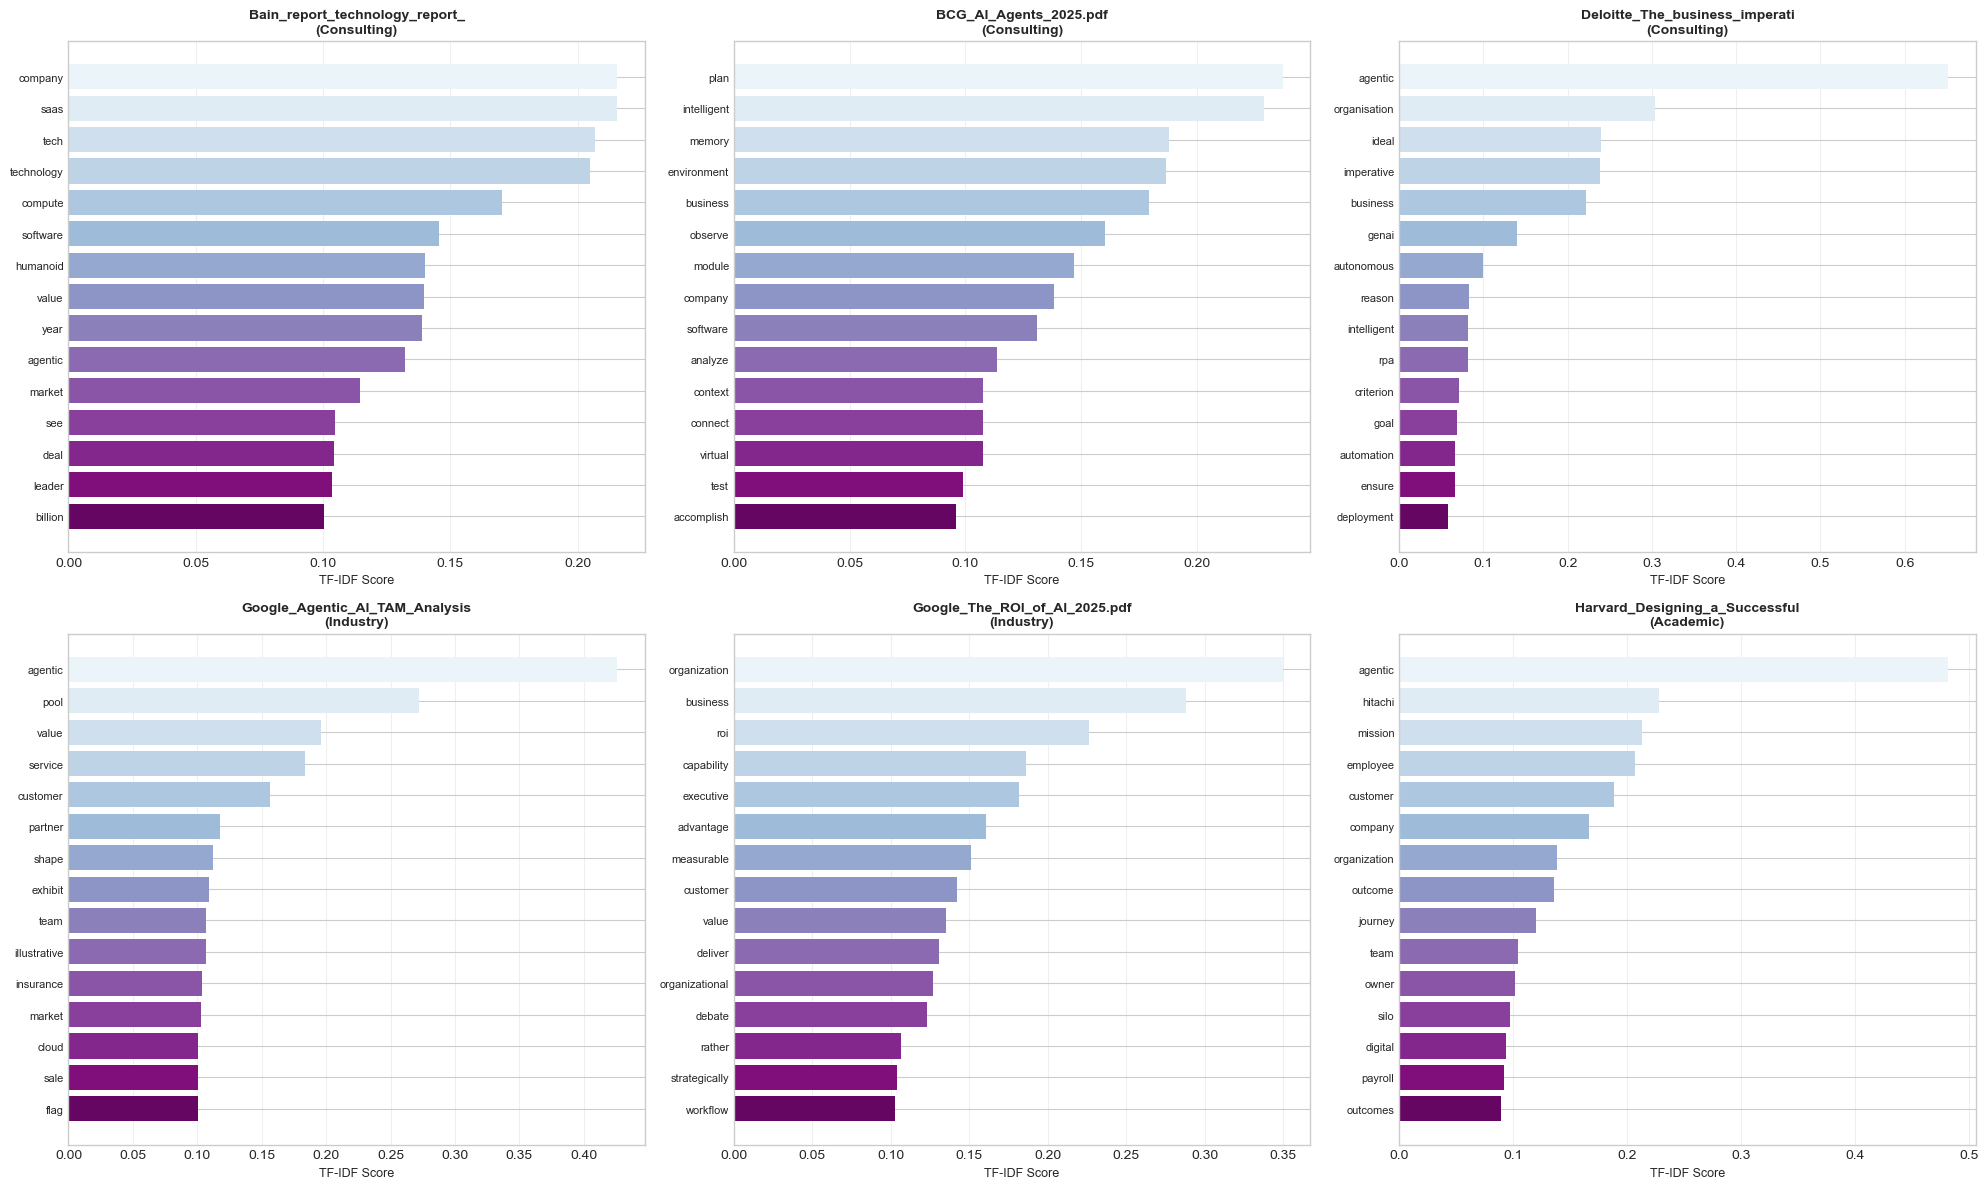

✔ Graph saved to: c:\Users\hrobi\Documents\GitHub\language-of-autonomy\data\processed\analysis\tfidf_top_terms_by_doc.png


In [32]:
n_docs_to_show = min(6, len(doc_ids_ordered))
docs_sample = doc_ids_ordered[:n_docs_to_show]

fig, axes = plt.subplots(2, 3, figsize=(20, 12))
axes = axes.flatten()

for idx, doc_id in enumerate(docs_sample):
    top_15 = list(top_terms_per_doc[doc_id].items())[:15]
    terms = [t[0] for t in top_15]
    scores = [t[1] for t in top_15]
    
    ax = axes[idx]
    colors = sns.color_palette('BuPu', len(top_15))
    ax.barh(range(15), scores, color=colors)
    ax.set_yticks(range(15))
    ax.set_yticklabels(terms, fontsize=8)
    ax.invert_yaxis()
    ax.set_xlabel('TF-IDF Score', fontsize=9)
    
    filename_short = metadata[doc_id]['filename'][:30]
    source_type = doc_to_source[doc_id]
    ax.set_title(f'{filename_short}\n({source_type})', fontsize=10, fontweight='bold')
    ax.grid(axis='x', alpha=0.3)

# (Optional) Delete empty axes if < 6 docs
for idx in range(n_docs_to_show, 6):
    fig.delaxes(axes[idx])

plt.tight_layout()
plt.savefig(ANALYSIS_DIR / 'tfidf_top_terms_by_doc.png', bbox_inches='tight')
plt.show()

print(f"✔ Graph saved to: {ANALYSIS_DIR / 'tfidf_top_terms_by_doc.png'}")

## Comparative analysis per source type

### Aggregation by source type (Consulting vs Academic vs Industry)

In [33]:
# Aggregate tokens per source type
tokens_by_source = defaultdict(list)

for doc_id, doc_data in processed_corpus.items():
    source_type = doc_to_source[doc_id]
    tokens_by_source[source_type].extend(doc_data['tokens'])

# Count frequencies by type
freq_by_source = {}
for source_type, tokens in tokens_by_source.items():
    freq_by_source[source_type] = Counter(tokens)
    total_tokens = len(tokens)
    vocab_size = len(freq_by_source[source_type])
    
    print(f"\n{source_type}:")
    print(f"  • Total tokens      : {total_tokens:,}")
    print(f"  • Unique vocabulary : {vocab_size:,}")
    print(f"  • Top 10 words:")
    
    for i, (word, count) in enumerate(freq_by_source[source_type].most_common(10), 1):
        print(f"    {i:2}. {word:20} : {count:5,}")


Consulting:
  • Total tokens      : 25,887
  • Unique vocabulary : 3,882
  • Top 10 words:
     1. agent                :   512
     2. agentic              :   354
     3. data                 :   242
     4. technology           :   189
     5. system               :   184
     6. company              :   181
     7. model                :   165
     8. business             :   158
     9. human                :   156
    10. process              :   143

Industry:
  • Total tokens      : 30,300
  • Unique vocabulary : 6,960
  • Top 10 words:
     1. agent                :   818
     2. system               :   430
     3. agentic              :   429
     4. model                :   203
     5. data                 :   187
     6. value                :   172
     7. service              :   166
     8. user                 :   166
     9. task                 :   164
    10. customer             :   152

Academic:
  • Total tokens      : 11,539
  • Unique vocabulary : 2,590
  • To

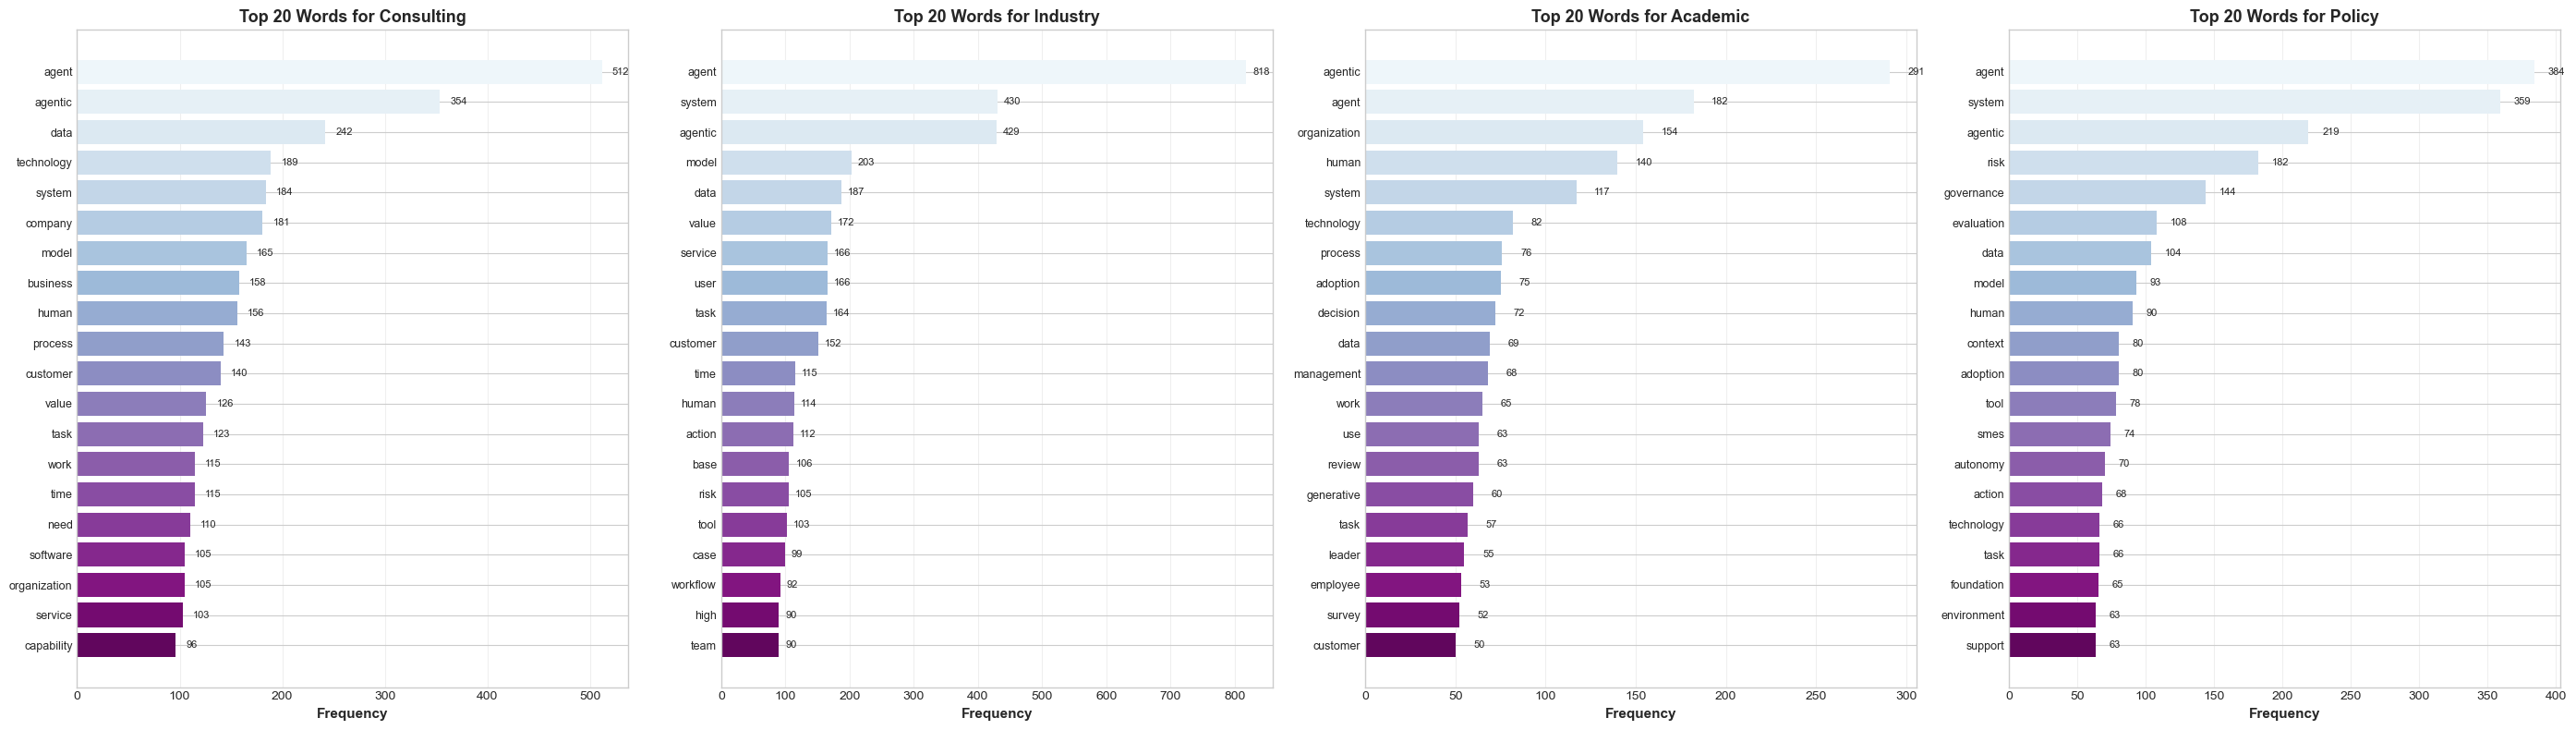

✔ Graph saved to: c:\Users\hrobi\Documents\GitHub\language-of-autonomy\data\processed\analysis\comparison_by_source_type.png


In [34]:
source_types = list(freq_by_source.keys())
n_sources = len(source_types)

fig, axes = plt.subplots(1, n_sources, figsize=(7*n_sources, 8))

if n_sources == 1:
    axes = [axes]

for idx, source_type in enumerate(source_types):
    top_20 = freq_by_source[source_type].most_common(20)
    words = [w for w, _ in top_20]
    counts = [c for _, c in top_20]
    
    ax = axes[idx]
    colors = sns.color_palette('BuPu', len(top_20))
    ax.barh(range(20), counts, color=colors)
    ax.set_yticks(range(20))
    ax.set_yticklabels(words, fontsize=9)
    ax.invert_yaxis()
    ax.set_xlabel('Frequency', fontsize=11, fontweight='bold')
    ax.set_title(f'Top 20 Words for {source_type}', fontsize=13, fontweight='bold')
    ax.grid(axis='x', alpha=0.3)
    
    for i, count in enumerate(counts):
        ax.text(count + 10, i, str(count), va='center', fontsize=8)

plt.tight_layout()
plt.savefig(ANALYSIS_DIR / 'comparison_by_source_type.png', bbox_inches='tight')
plt.show()

print(f"✔ Graph saved to: {ANALYSIS_DIR / 'comparison_by_source_type.png'}")

### Distinctive terms by source type (TF-IDF inter-types)

In [35]:
# Create "documents" per type (via aggregation)
docs_by_type = []
types_ordered = []

for source_type, tokens in tokens_by_source.items():
    docs_by_type.append(' '.join(tokens))
    types_ordered.append(source_type)

# TF-IDF on types
tfidf_types = TfidfVectorizer(max_features=100, ngram_range=(1, 1))
tfidf_matrix_types = tfidf_types.fit_transform(docs_by_type)
feature_names_types = tfidf_types.get_feature_names_out()

# Extract top terms per type
print("\nTop 20 distinctive terms per type:\n")

for idx, source_type in enumerate(types_ordered):
    scores = tfidf_matrix_types[idx].toarray()[0]
    top_indices = scores.argsort()[-20:][::-1]
    
    print(f"{source_type}:")
    
    for i, term_idx in enumerate(top_indices, 1):
        term = feature_names_types[term_idx]
        score = scores[term_idx]
        print(f"  {i:2}. {term:25} : {score:.4f}")
    print()


Top 20 distinctive terms per type:

Consulting:
   1. agent                     : 0.5078
   2. agentic                   : 0.3511
   3. data                      : 0.2400
   4. technology                : 0.1874
   5. system                    : 0.1825
   6. company                   : 0.1795
   7. model                     : 0.1636
   8. business                  : 0.1567
   9. human                     : 0.1547
  10. process                   : 0.1418
  11. customer                  : 0.1388
  12. value                     : 0.1250
  13. task                      : 0.1220
  14. work                      : 0.1141
  15. time                      : 0.1141
  16. need                      : 0.1091
  17. software                  : 0.1041
  18. organization              : 0.1041
  19. service                   : 0.1022
  20. capability                : 0.0952

Industry:
   1. agent                     : 0.6552
   2. system                    : 0.3444
   3. agentic                   : 0.34

### WordClouds per source type

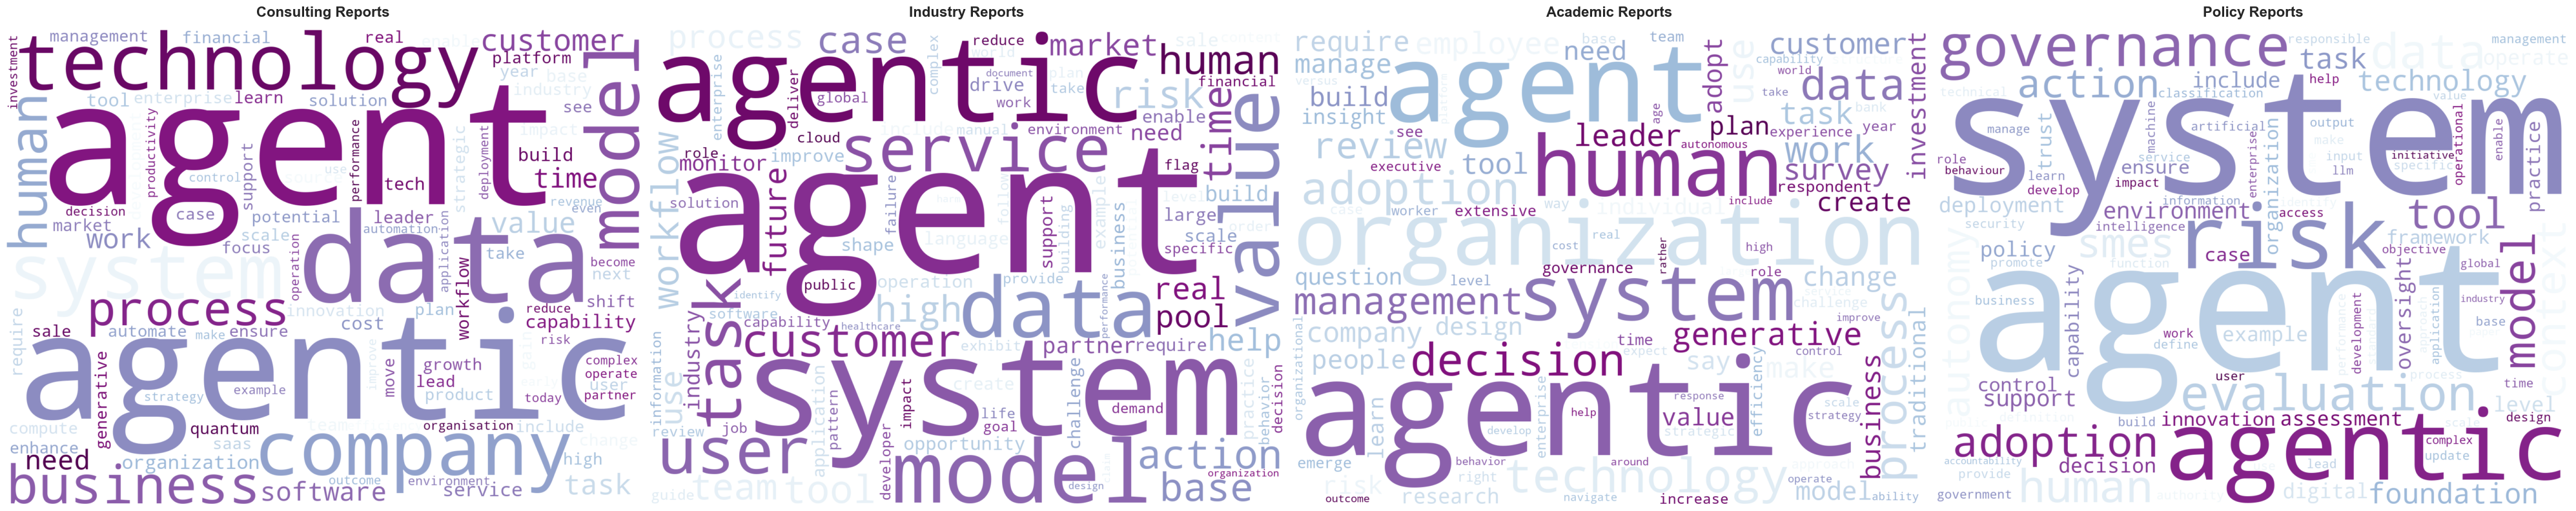

✔ WordClouds saved to: c:\Users\hrobi\Documents\GitHub\language-of-autonomy\data\processed\analysis\wordclouds_by_source_type.png


In [36]:
# Create WordCloud for each type
n_sources = len(source_types)
fig, axes = plt.subplots(1, n_sources, figsize=(10*n_sources, 8))

if n_sources == 1:
    axes = [axes]

for idx, source_type in enumerate(source_types):
    # Generate WordCloud
    wordcloud = WordCloud(
        width=1600,
        height=1200,
        background_color='white',
        colormap='BuPu',
        max_words=100,
        relative_scaling=0.5,
        collocations=False
    ).generate_from_frequencies(freq_by_source[source_type])
    
    ax = axes[idx]
    ax.imshow(wordcloud, interpolation='bilinear')
    ax.axis('off')
    ax.set_title(f'{source_type} Reports', fontsize=16, fontweight='bold', pad=15)

plt.tight_layout()
plt.savefig(ANALYSIS_DIR / 'wordclouds_by_source_type.png', bbox_inches='tight')
plt.show()

print(f"✔ WordClouds saved to: {ANALYSIS_DIR / 'wordclouds_by_source_type.png'}")

### Key terms categories analysis per type

In [37]:
# Count terms by category for each type
category_by_source = defaultdict(lambda: defaultdict(int))

for source_type, tokens in tokens_by_source.items():
    token_freq = Counter(tokens)
    
    for category, terms in KEY_TERMS.items():
        for term in terms:
            category_by_source[source_type][category] += token_freq.get(term, 0)

# DataFrame for viz
data_cat_comparison = []
for source_type, categories in category_by_source.items():
    for category, count in categories.items():
        data_cat_comparison.append({
            'source_type': source_type,
            'category': category,
            'count': count
        })

df_cat_comparison = pd.DataFrame(data_cat_comparison)

In [38]:
print("\nOccurrences per category and type:\n")
pivot_table = df_cat_comparison.pivot(index='category', columns='source_type', values='count')
pivot_table = pivot_table.fillna(0).astype(int)
pivot_table


Occurrences per category and type:



source_type     Academic  Consulting  Industry  Policy
category                                              
Assistance           144         260       231     223
Business Value       175         513       384     128
Core Concepts        534        1061      1351     769
Governance           234         254       277     597
Implementation       235         643       798     676
Operations           181         504       587     178
Technology           141         397       232     158
Workforce            531         738       365     237

### Category by type visualization

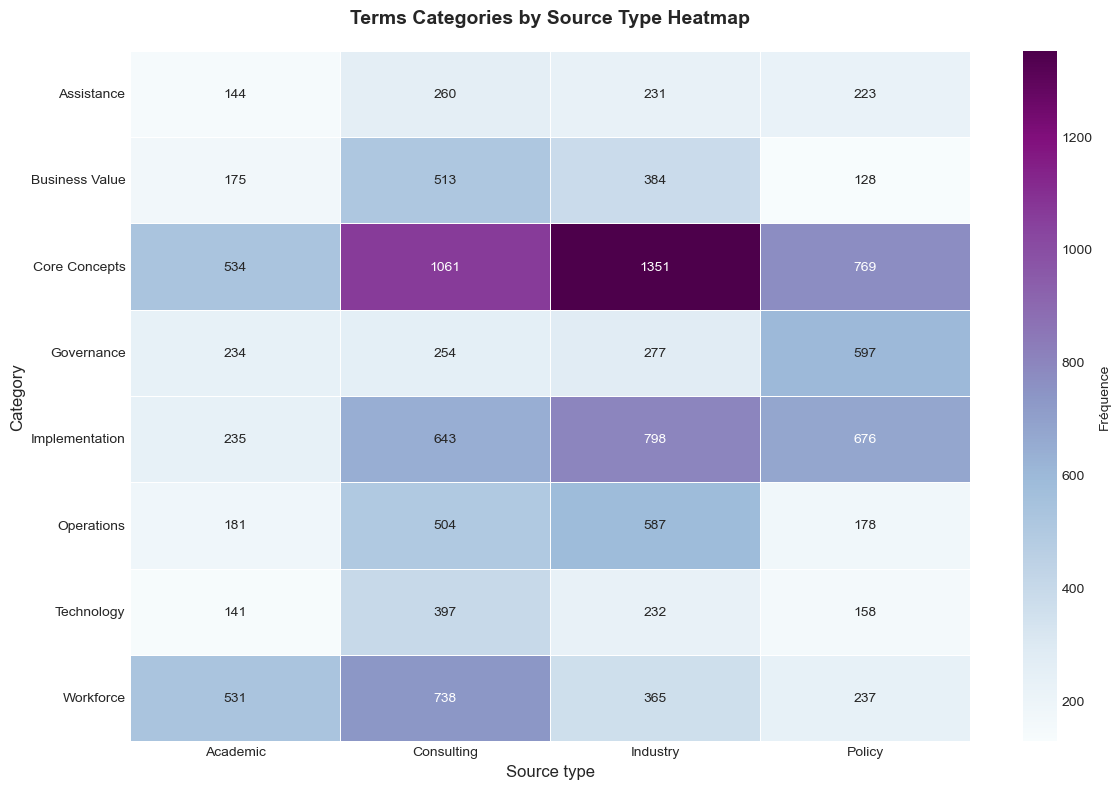

✔ Heatmap saved to: c:\Users\hrobi\Documents\GitHub\language-of-autonomy\data\processed\analysis\heatmap_categories_by_source.png


In [39]:
# Category by type heatmap
fig, ax = plt.subplots(figsize=(12, 8))

sns.heatmap(pivot_table, annot=True, fmt='d', cmap='BuPu', 
            linewidths=0.5, cbar_kws={'label': 'Fréquence'}, ax=ax)

ax.set_title('Terms Categories by Source Type Heatmap', 
             fontsize=14, fontweight='bold', pad=20)
ax.set_xlabel('Source type', fontsize=12)
ax.set_ylabel('Category', fontsize=12)

plt.tight_layout()
plt.savefig(ANALYSIS_DIR / 'heatmap_categories_by_source.png', bbox_inches='tight')
plt.show()

print(f"✔ Heatmap saved to: {ANALYSIS_DIR / 'heatmap_categories_by_source.png'}")

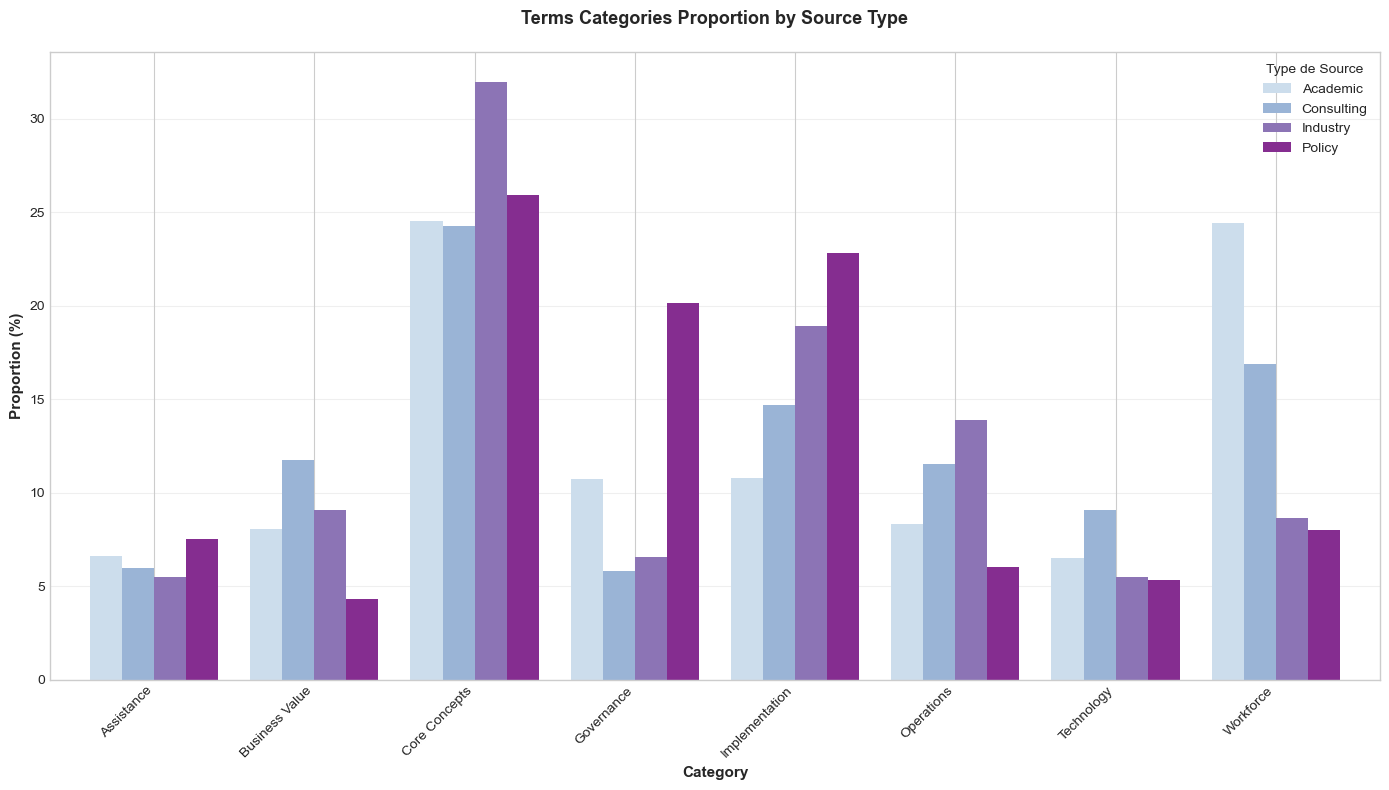

✔ Graph saved to: c:\Users\hrobi\Documents\GitHub\language-of-autonomy\data\processed\analysis\categories_proportion_by_source.png


In [40]:
# Graphique à barres groupées
pivot_table_pct = pivot_table.div(pivot_table.sum(axis=0), axis=1) * 100

fig, ax = plt.subplots(figsize=(14, 8))

colors = sns.color_palette('BuPu', len(pivot_table_pct.columns))
pivot_table_pct.plot(kind='bar', ax=ax, width=0.8, color=colors)

ax.set_ylabel('Proportion (%)', fontsize=11, fontweight='bold')
ax.set_xlabel('Category', fontsize=11, fontweight='bold')
ax.set_title('Terms Categories Proportion by Source Type', 
             fontsize=13, fontweight='bold', pad=20)
ax.legend(title='Type de Source', fontsize=10)
ax.grid(axis='y', alpha=0.3)

plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig(ANALYSIS_DIR / 'categories_proportion_by_source.png', bbox_inches='tight')
plt.show()

print(f"✔ Graph saved to: {ANALYSIS_DIR / 'categories_proportion_by_source.png'}")

## Save results

In [41]:
# Save global frequencies
df_global_freq = pd.DataFrame(
    global_freq.most_common(500),
    columns=['word', 'frequency']
)
df_global_freq.to_csv(ANALYSIS_DIR / 'global_word_frequencies.csv', index=False)
print(f"✔ Global frequencies: {ANALYSIS_DIR / 'global_word_frequencies.csv'}")

✔ Global frequencies: c:\Users\hrobi\Documents\GitHub\language-of-autonomy\data\processed\analysis\global_word_frequencies.csv


In [42]:
# Save TF-IDF top terms per doc
tfidf_results = []
for doc_id, terms_dict in top_terms_per_doc.items():
    filename = metadata[doc_id]['filename']
    source_type = doc_to_source[doc_id]
    
    for rank, (term, score) in enumerate(terms_dict.items(), 1):
        tfidf_results.append({
            'document_id': doc_id,
            'filename': filename,
            'source_type': source_type,
            'rank': rank,
            'term': term,
            'tfidf_score': score
        })

df_tfidf = pd.DataFrame(tfidf_results)
df_tfidf.to_csv(ANALYSIS_DIR / 'tfidf_top_terms_by_document.csv', index=False)
print(f"✔ TF-IDF par document: {ANALYSIS_DIR / 'tfidf_top_terms_by_document.csv'}")

✔ TF-IDF par document: c:\Users\hrobi\Documents\GitHub\language-of-autonomy\data\processed\analysis\tfidf_top_terms_by_document.csv


In [43]:
# Save bigrams and trigrams
df_bigrams = pd.DataFrame(
    [(' '.join(bg), count) for bg, count in bigram_freq.most_common(100)],
    columns=['bigram', 'frequency']
)
df_bigrams.to_csv(ANALYSIS_DIR / 'top_bigrams.csv', index=False)
print(f"✔ Top bigrams: {ANALYSIS_DIR / 'top_bigrams.csv'}")

df_trigrams = pd.DataFrame(
    [(' '.join(tg), count) for tg, count in trigram_freq.most_common(100)],
    columns=['trigram', 'frequency']
)
df_trigrams.to_csv(ANALYSIS_DIR / 'top_trigrams.csv', index=False)
print(f"✔ Top trigrams: {ANALYSIS_DIR / 'top_trigrams.csv'}")

✔ Top bigrams: c:\Users\hrobi\Documents\GitHub\language-of-autonomy\data\processed\analysis\top_bigrams.csv
✔ Top trigrams: c:\Users\hrobi\Documents\GitHub\language-of-autonomy\data\processed\analysis\top_trigrams.csv


In [44]:
# Save co-occurrences
for target, cooccur in cooccurrence_results.items():
    df_cooccur = pd.DataFrame(
        cooccur.most_common(50),
        columns=['cooccurring_word', 'frequency']
    )
    df_cooccur['target_word'] = target
    df_cooccur.to_csv(ANALYSIS_DIR / f'cooccurrences_{target}.csv', index=False)

print(f"✔ Co-occurrences save for: {', '.join(TARGET_WORDS)}")

✔ Co-occurrences save for: agent, agentic, autonomy, autonomous, ai


In [45]:
# Save comparaison per type
df_cat_comparison.to_csv(ANALYSIS_DIR / 'categories_by_source_type.csv', index=False)
print(f"✔ Categories by type: {ANALYSIS_DIR / 'categories_by_source_type.csv'}")

✔ Categories by type: c:\Users\hrobi\Documents\GitHub\language-of-autonomy\data\processed\analysis\categories_by_source_type.csv


In [46]:
# Save detailed key terms
df_key_terms.to_csv(ANALYSIS_DIR / 'key_terms_frequencies.csv', index=False)
print(f"✔ Key terms: {ANALYSIS_DIR / 'key_terms_frequencies.csv'}")

✔ Key terms: c:\Users\hrobi\Documents\GitHub\language-of-autonomy\data\processed\analysis\key_terms_frequencies.csv


## Insights summary

In [47]:
# Insight 1: Most frequent words
print("\n✔ TOP 10 GLOBAL WORDS:")
for word, count in global_freq.most_common(10):
    print(f"   • {word:15} : {count:,} occurrences")

# Insight 2: Dominant categories
print("\n✔ DOMINANT CATEGORIES:")
for category, count in sorted(category_counts.items(), key=lambda x: x[1], reverse=True)[:5]:
    print(f"   • {category:20} : {count:,} occurrences")

# Insight 3: Key bigrams
print("\n✔ TOP 5 SIGNIFICATIVE BIGRAMS:")
for bigram in top_bigrams_pmi[:5]:
    bigram_str = ' '.join(bigram)
    count = bigram_freq[bigram]
    print(f"   • {bigram_str:30} : {count:,} occurrences")

# Insight 4: Differences per type
print("\n✔ EMPHASIS PER SOURCE TYPE:")
for source_type in source_types:
    top_3 = freq_by_source[source_type].most_common(3)
    words_str = ', '.join([w for w, _ in top_3])
    print(f"   • {source_type:15} : {words_str}")

# Insight 5: Co-occurrences with "agent"
print("\n✔ TOP 5 CO-OCCURRENCES WITH 'AGENT':")
for word, count in cooccurrence_results['agent'].most_common(5):
    print(f"   • {word:20} : {count:,}")


✔ TOP 10 GLOBAL WORDS:
   • agent           : 1,896 occurrences
   • agentic         : 1,293 occurrences
   • system          : 1,090 occurrences
   • data            : 602 occurrences
   • model           : 502 occurrences
   • human           : 500 occurrences
   • task            : 410 occurrences
   • risk            : 375 occurrences
   • technology      : 371 occurrences
   • value           : 362 occurrences

✔ DOMINANT CATEGORIES:
   • Core Concepts        : 3,715 occurrences
   • Implementation       : 2,352 occurrences
   • Workforce            : 1,871 occurrences
   • Operations           : 1,450 occurrences
   • Governance           : 1,362 occurrences

✔ TOP 5 SIGNIFICATIVE BIGRAMS:
   • await runner                   : 5 occurrences
   • iso iec                        : 5 occurrences
   • explanatory memorandum         : 18 occurrences
   • regional split                 : 6 occurrences
   • fine tune                      : 15 occurrences

✔ EMPHASIS PER SOURCE TYPE:
   